In [1]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import matplotlib.colors as mcolors
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [2]:
# Import data frames
train_df = pd.read_pickle('data-2/train_df.pkl')
val_df = pd.read_pickle('data-2/val_df.pkl')

In [121]:
kp_names = [ "nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", 
    "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle" ]

kp_dict = {name:i*2 for i, name in enumerate(kp_names)}
print(kp_dict)

# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        if(i > 1 and i < 10): 
            continue
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        colors = ['red', 'blue', 'magenta', 'lime', 'orange', 'purple', 'pink', 'yellow', 'aqua', 'fuchsia', 'azure', 'lavender', 'magenta', 'white', 'sienna', 'indigo', 'coral']
        #ax.plot(x, y, marker='x', color=colors[i//2])
        ax.plot(x, y, marker='o', color='black')

    # draw skeleton
    left_arm = ["left_shoulder", "left_elbow", "left_wrist"]
    right_arm = ["right_shoulder", "right_elbow", "right_wrist"]
    left_leg = ["left_hip", "left_knee", "left_ankle"]
    right_leg = ["right_hip", "right_knee", "right_ankle"]

    bones = [left_arm, right_arm, left_leg, right_leg]
    colors = ['red', 'blue', 'green', 'yellow']

    for i, bone in enumerate(bones):
        x_l = []
        y_l = []
        for keypoint in bone:
            idx = kp_dict[keypoint]
            x = keypoints[idx]*w + w/2
            y = keypoints[idx+1]*h + h/2
            if x < 0 or y < 0: continue
            x_l.append(x)
            y_l.append(y)
        
        ax.plot(x_l, y_l, color=colors[i], linewidth=2)
        print(x_l)
        print(y_l)
    
    # torso:
    torso_upper_x = (keypoints[kp_dict["left_shoulder"]] + keypoints[kp_dict["right_shoulder"]])/2 * w + w/2
    torso_upper_y = (keypoints[kp_dict["left_shoulder"]+1] + keypoints[kp_dict["right_shoulder"]+1])/2 * h + h/2
    torso_lower_x = (keypoints[kp_dict["left_hip"]] + keypoints[kp_dict["right_hip"]])/2 * w + w/2
    torso_lower_y = (keypoints[kp_dict["left_hip"]+1] + keypoints[kp_dict["right_hip"]+1])/2 * h + h/2
    torso_x = [torso_upper_x, torso_lower_x]
    torso_y = [torso_upper_y, torso_lower_y]
    ax.plot(torso_x, torso_y, color='magenta', linewidth=2)

    # connectors 
    face_c_x = [torso_upper_x, keypoints[kp_dict["nose"]]*w + w/2]
    face_c_y = [torso_upper_y, keypoints[kp_dict["nose"]+1]*h + h/2]
    ax.plot(face_c_x, face_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["left_shoulder"]]*w + w/2]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["left_shoulder"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["right_shoulder"]]*w + w/2]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["right_shoulder"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["left_hip"]]*w + w/2]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["left_hip"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["right_hip"]]*w + w/2]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["right_hip"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    if(show):
        plt.show()

{'nose': 0, 'left_eye': 2, 'right_eye': 4, 'left_ear': 6, 'right_ear': 8, 'left_shoulder': 10, 'right_shoulder': 12, 'left_elbow': 14, 'right_elbow': 16, 'left_wrist': 18, 'right_wrist': 20, 'left_hip': 22, 'right_hip': 24, 'left_knee': 26, 'right_knee': 28, 'left_ankle': 30, 'right_ankle': 32}


In [4]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [5]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data-2/{self.source}2017/{self.df.iloc[index]["path"]}')
        
        # Apply transforms to image
        if self.transform: img = self.transform(img)

        label = torch.FloatTensor(self.df.iloc[index]["keypoints"])

        # random augmentation
        
        
        # Return data
        return img, label

    def __len__(self):
        return len(self.df)

[tensor(159.6832), tensor(161.9010), tensor(146.3762)]
[tensor(49.6432), tensor(96.8649), tensor(124.7135)]
[tensor(73.1881), tensor(53.2277), tensor(66.5347)]
[tensor(46.0108), tensor(81.1243), tensor(115.0270)]
[tensor(139.7228), tensor(179.6436), tensor(195.1683)]
[tensor(113.8162), tensor(151.3513), tensor(204.6270)]
[tensor(79.8416), tensor(51.0099), tensor(24.3960)]
[tensor(113.8162), tensor(152.5622), tensor(198.5730)]


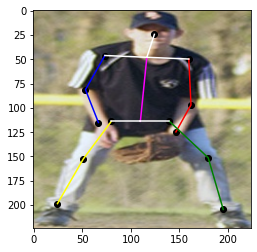

In [126]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=True, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
#print(labels)
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [28]:
# Initialize network
'''
model = models.resnet18(pretrained=True)#models.mobilenet_v2(pretrained=True)

# Freeze params
'''
#for param in model.parameters():
#    param.requires_grad = False
'''

# Replace FC
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False), 
    torch.nn.Linear(512, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 34),
    torch.nn.Sigmoid()
    ) 
model = model.to(device)
model
'''

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4,4), padding=(5,5)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(96),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2,2)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),

    torch.nn.Linear(12544, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 34),
)

model = model.to(device)
model(torch.rand(32,3,224, 224).to('cuda')).shape


torch.Size([32, 34])

In [15]:
model.load_state_dict(torch.load("model.save", map_location=device))

<All keys matched successfully>

In [29]:
val_dataset = Coco(val_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs) - 0.5
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    '''
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu') - 0.5

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)
    '''
    return loss 
    

check_validation_accuracy(model)

Validiation loss was 1.8128951787948608


tensor(1.8129, device='cuda:0')

Training 100 epochs. Dataset is 4037 big. Using batch size 64
64 minibatches are needed per epoch
Minibatch 1/64. Loss 0.006885925307869911
Minibatch 51/64. Loss 0.007402271032333374
Epoch 0/2. Loss 0.48759952932596207
Validiation loss was 0.07923147827386856
Minibatch 1/64. Loss 0.008111666887998581
Minibatch 51/64. Loss 0.008044118992984295
Epoch 1/2. Loss 0.4838238316588104
Validiation loss was 0.07433468103408813
Minibatch 1/64. Loss 0.008113918825984001
Minibatch 51/64. Loss 0.006468513049185276
Epoch 2/2. Loss 0.4856541189365089
Validiation loss was 0.07680977880954742
Minibatch 1/64. Loss 0.007877242751419544
Minibatch 51/64. Loss 0.007996078580617905
Epoch 3/2. Loss 0.4842330878600478
Validiation loss was 0.07537105679512024
Minibatch 1/64. Loss 0.006249023601412773
Minibatch 51/64. Loss 0.007246425841003656
Epoch 4/2. Loss 0.4859281121753156
Validiation loss was 0.07707599550485611
Minibatch 1/64. Loss 0.0071329581551253796
Minibatch 51/64. Loss 0.006897716782987118
Epoch 5/2.

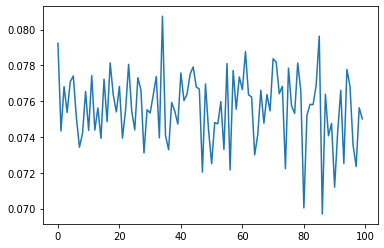

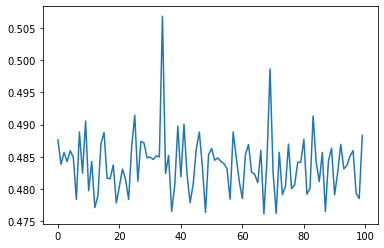

In [81]:
# TRAINING
train_dataset = Coco(train_df, 'train', 224, transform=composed_transforms)
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.0001)#optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 100

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) - 0.5
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))
    if(epoch % 100 == 0):
        torch.save(model.state_dict(), f'models/model_{epoch}.save')

# save model
plt.plot(val_loss_history)
plt.figure()
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')

[tensor(155.9704), tensor(195.7926), tensor(197.4518)]
[tensor(49.2800), tensor(36.9600), tensor(16.8000)]
[tensor(94.5778), tensor(54.7556), tensor(56.4148)]
[tensor(49.2800), tensor(35.8400), tensor(12.3200)]
[tensor(149.3333), tensor(182.5185), tensor(207.4074)]
[tensor(113.1200), tensor(145.6000), tensor(201.6000)]
[tensor(97.8963), tensor(69.6889), tensor(66.3704)]
[tensor(112.), tensor(146.7200), tensor(202.7200)]
[238.24814987182617, 258.85620498657227, 255.5209617614746]
[74.3403263092041, 119.84732246398926, 118.42815780639648]
[123.89303588867188, 91.96540927886963, 87.74941158294678]
[51.734768867492676, 106.5833740234375, 103.17133331298828]
[187.52242279052734, 185.8297939300537, 185.2139720916748]
[139.44869232177734, 201.49274253845215, 245.49832916259766]
[104.54331398010254, 103.58634281158447, 99.80486106872559]
[131.06643104553223, 195.78266525268555, 244.29637908935547]


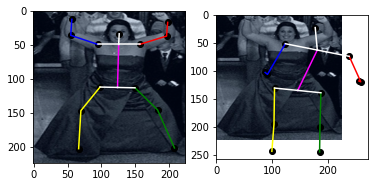

[tensor(123.5140), tensor(110.9533), tensor(165.3832)]
[tensor(50.6911), tensor(80.1468), tensor(95.9021)]
[tensor(85.8318), tensor(98.3925), tensor(94.2056)]
[tensor(46.5810), tensor(51.3761), tensor(50.6911)]
[tensor(100.4860), tensor(110.9533), tensor(110.9533)]
[tensor(126.0428), tensor(159.6086), tensor(206.8746)]
[tensor(69.0841), tensor(64.8972), tensor(50.2430)]
[tensor(131.5229), tensor(171.2538), tensor(221.9449)]
[142.18202590942383, 146.46066856384277, 157.8130111694336]
[40.77853012084961, 98.67490196228027, 105.47244071960449]
[48.653663635253906, 37.46017646789551, 51.95198345184326]
[61.20741558074951, 59.361385345458984, 97.21462821960449]
[120.8015365600586, 124.27157592773438, 128.01334381103516]
[123.22009658813477, 143.00838661193848, 182.38765907287598]
[62.70609474182129, 59.59613037109375, 66.94106483459473]
[114.80370903015137, 162.0430145263672, 195.97365760803223]


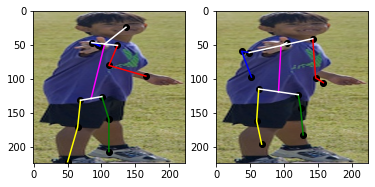

[tensor(154.4421), tensor(167.4105), tensor(199.2421)]
[tensor(38.9565), tensor(63.7470), tensor(55.7787)]
[tensor(126.1474), tensor(80.1684), tensor(30.6526)]
[tensor(32.7589), tensor(41.6126), tensor(30.9881)]
[tensor(152.0842), tensor(173.3053), tensor(167.4105)]
[tensor(94.7352), tensor(142.5455), tensor(198.3241)]
[tensor(136.7579), tensor(110.8211), tensor(63.6632)]
[tensor(92.9644), tensor(139.8893), tensor(200.0949)]
[161.2693386077881, 155.60907554626465, 128.44265937805176]
[47.887718200683594, 70.45262050628662, 90.27923583984375]
[50.22480773925781, 34.4727783203125, 39.21580410003662]
[55.922635078430176, 110.24495315551758, 108.5854959487915]
[126.4782886505127, 136.58112335205078, 137.3001651763916]
[105.75814151763916, 132.77068901062012, 179.1045799255371]
[88.23118495941162, 83.31633949279785, 100.2416934967041]
[114.23397636413574, 136.04758644104004, 191.84047889709473]


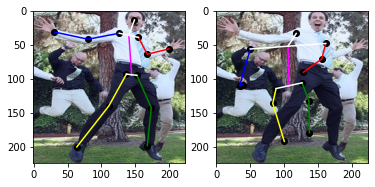

[tensor(174.6956), tensor(205.7391), tensor(177.1304)]
[tensor(75.7239), tensor(100.3044), tensor(105.0620)]
[tensor(116.2609), tensor(82.1739), tensor(108.9565)]
[tensor(77.3097), tensor(98.3221), tensor(109.0266)]
[tensor(169.2174), tensor(215.4783), tensor(140.)]
[tensor(132.4177), tensor(158.9805), tensor(183.5611)]
[tensor(123.5652), tensor(54.7826), tensor(48.6957)]
[tensor(131.6248), tensor(141.9327), tensor(184.7504)]
[153.69621467590332, 170.462739944458, 172.83055114746094]
[57.36160659790039, 105.91638278961182, 92.7445125579834]
[68.82240962982178, 59.526469230651855, 72.43426132202148]
[60.281646728515625, 97.77199745178223, 93.20384883880615]
[154.6747283935547, 163.32308387756348, 116.35560035705566]
[136.87418746948242, 138.39984321594238, 187.65906143188477]
[87.77241611480713, 60.66023349761963, 55.57800102233887]
[131.88618278503418, 144.82723999023438, 175.77960395812988]


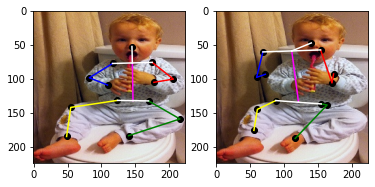

[tensor(181.6889), tensor(200.3556), tensor(130.6667)]
[tensor(66.3439), tensor(117.7070), tensor(125.5541)]
[tensor(72.1778), tensor(77.1556), tensor(37.3333)]
[tensor(62.0637), tensor(114.1401), tensor(95.5924)]
[tensor(159.2889), tensor(108.2667), tensor(103.2889)]
[tensor(149.8089), tensor(163.3631), tensor(217.5796)]
[tensor(103.2889), tensor(49.7778), tensor(47.2889)]
[tensor(146.9554), tensor(140.5350), tensor(211.8726)]
[183.2726058959961, 219.00298309326172, 203.26766967773438]
[54.92646408081055, 106.03364181518555, 123.7153148651123]
[78.09808254241943, 54.75571918487549, 87.49642181396484]
[44.73679161071777, 78.7881851196289, 102.75334644317627]
[165.2676944732666, 187.46437072753906, 190.72987937927246]
[139.79628372192383, 173.53824424743652, 204.38964462280273]
[76.81621074676514, 80.86166381835938, 67.8054370880127]
[139.40472602844238, 148.8267707824707, 230.8375129699707]


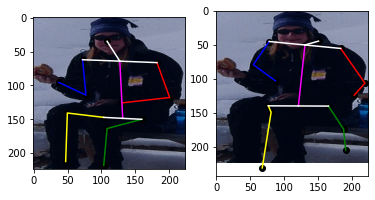

tensor([ 0.1725, -0.3028,  0.1580, -0.4681,  0.0351, -0.3942,  0.2195, -0.3040,
        -0.0032, -0.3437,  0.3182, -0.2548, -0.1513, -0.3003,  0.4777, -0.0266,
        -0.2556, -0.1483,  0.4074,  0.0523, -0.1094, -0.0413,  0.2378,  0.1241,
        -0.1571,  0.1223,  0.3369,  0.2747, -0.1390,  0.1644,  0.3515,  0.4125,
        -0.1973,  0.5305], grad_fn=<SelectBackward0>)


In [128]:
for q in range(0, 5):
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)

    img = img.to(device)
    outputs = model(img.unsqueeze(0)) - 0.5
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

print(outputs[0])